In [127]:
try: 
    # Tensoeflow_version only exists in colab
    %tensorflow_version 2.x
except Exception:
    pass

In [128]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.utils.vis_utils import plot_model
import pandas as pd


In [129]:
def format_Output(data):
    y1=data.pop('Y1')
    y1=np.array(y1)
    y2=data.pop('Y2')
    y2=np.array(y2)
    return y1,y2

In [130]:
def norm(X):
    return ((X-train_stats['mean'])/train_stats['std'])

In [131]:
def plot_diff(y_true, y_pred, title=''):
    
    plt.scatter(y_true,y_pred)
    plt.title(title)
    plt.xlabel('True value')
    plt.ylabel('Prediction')
    plt.axis('equal')
    plt.axis('square')
    plt.ylim(plt.ylim())
    plt.xlim(plt.xlim())
    plt.plot([-100, 100],[-100, 100])
    plt.show()

In [132]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name], color='blue',label=metric_name)
    plt.plot(history.history['val_'+metric_name],color='green',label='val_'+metric_name)
    plt.show()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_layer (InputLayer)        [(None, 8)]          0                                            
__________________________________________________________________________________________________
First_Danse_layer (Dense)       (None, 128)          1152        Input_layer[0][0]                
__________________________________________________________________________________________________
Second_Danse_Layer (Dense)      (None, 128)          16512       First_Danse_layer[0][0]          
__________________________________________________________________________________________________
Third_Danse_Layer (Dense)       (None, 64)           8256        Second_Danse_Layer[0][0]         
___________________________________________________________________________________________

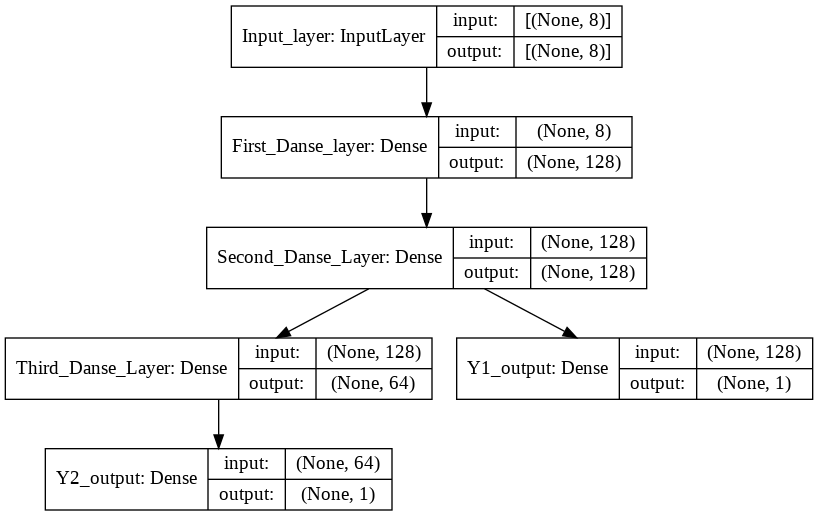

In [133]:
# Get the data from UCI dataset.

URL= 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

#Use Pandas for excel reader

df=pd.read_excel(URL)

df=df.sample(frac=1).reset_index(drop=True)

# Split he dataset into Train and Test with 80 train and 20 test

train, test = train_test_split(df,test_size=0.2)
train_stats=train.describe()

train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats=train_stats.transpose()


train_y = format_Output(train)
test_y = format_Output(test)

#Normalize the train and test data
norm_train_x= norm(train)
norm_test_x= norm(test)

#Define model layers

input_layer=Input(shape=(len(train.columns,)), name='Input_layer')
first_dense = Dense(units='128',activation='relu',name='First_Danse_layer')(input_layer)
Second_dense= Dense(units='128', activation='relu', name='Second_Danse_Layer')(first_dense)

# Y1 Output will be fed dirctly form the second layer 

Y1_output = Dense(units='1', name='Y1_output')(Second_dense)
third_dense=Dense(units='64', activation='relu', name='Third_Danse_Layer')(Second_dense)

#Y2 Output will come via the third dense layer
Y2_output = Dense(units='1', name='Y2_output')(third_dense)

# Define the model with the input layer and a list of out_put layers

model = Model(inputs=input_layer,outputs=[Y1_output, Y2_output])

print(model.summary())

# Specify the optimizer and compile the model wiht loss function for both output

optimizer=tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=optimizer, 
              loss={'Y1_output':'mse', 'Y2_output':'mse'},
              metrics={'Y1_output':tf.keras.metrics.RootMeanSquaredError(),
                       'Y2_output':tf.keras.metrics.RootMeanSquaredError()})

from tensorflow.keras.layers import Layer
model._layers=[
              layer for layer in model._layers if isinstance(layer, Layer)
              ]

plot_model(model)

plot_model(model, show_shapes=True,
           show_layer_names=True,
           to_file='model.png')

Epoch 1/2000
62/62 [==============================] - 1s 6ms/step - loss: 599.6302 - Y1_output_loss: 293.0472 - Y2_output_loss: 306.5830 - Y1_output_root_mean_squared_error: 16.3460 - Y2_output_root_mean_squared_error: 16.6421 - val_loss: 26.3083 - val_Y1_output_loss: 11.4400 - val_Y2_output_loss: 14.8682 - val_Y1_output_root_mean_squared_error: 3.3823 - val_Y2_output_root_mean_squared_error: 3.8559
Epoch 2/2000
62/62 [==============================] - 0s 2ms/step - loss: 36.5515 - Y1_output_loss: 14.9559 - Y2_output_loss: 21.5956 - Y1_output_root_mean_squared_error: 3.8648 - Y2_output_root_mean_squared_error: 4.6277 - val_loss: 19.9530 - val_Y1_output_loss: 7.8481 - val_Y2_output_loss: 12.1049 - val_Y1_output_root_mean_squared_error: 2.8014 - val_Y2_output_root_mean_squared_error: 3.4792
Epoch 3/2000
62/62 [==============================] - 0s 2ms/step - loss: 29.9560 - Y1_output_loss: 11.7924 - Y2_output_loss: 18.1636 - Y1_output_root_mean_squared_error: 3.4316 - Y2_output_root_mean_

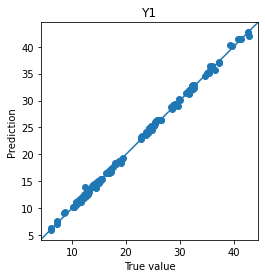

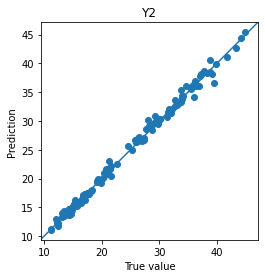

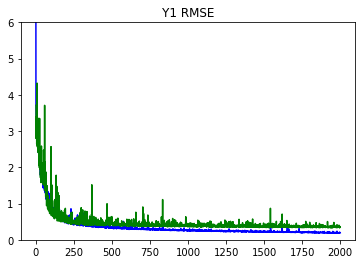

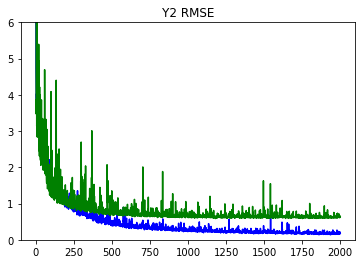

In [134]:
# train the model for 2000 epochs

history = model.fit(norm_train_x,train_y,
                    epochs=2000, batch_size=10,
                    validation_data=(norm_test_x,test_y))


#Test the model and print loss ans RMSE for both output

loss, Y1_loss, Y2_loss,  Y1_RMSE, Y2_RMSE = model.evaluate(x=norm_test_x, y=test_y)

print('\n')
print('Loss= {}, Y1_loss= {}, Y1_RMSE= {},Y2_loss= {}, Y2_RMSE= {}'
      .format(loss, Y1_loss, Y1_RMSE, Y2_loss, Y2_RMSE))

# Plot Loss and RMSE

y_pred=model.predict(norm_test_x)

plot_diff(test_y[0], y_pred[0],title='Y1')

plot_diff(test_y[1], y_pred[1],title='Y2')


plot_metrics(metric_name='Y1_output_root_mean_squared_error',title='Y1 RMSE',ylim=6)


plot_metrics(metric_name='Y2_output_root_mean_squared_error',title='Y2 RMSE',ylim=6)
